In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use("ggplot")

In [2]:
# ugly hack to get relative imports working
import os
os.chdir("..")

In [3]:
def hazard(p):
    def geometric(t):
        return p * (1 - p) ** t
    return geometric

In [4]:
def plot_result(data, run_lengths):
    df = pd.DataFrame({"data": data, "run_length": run_lengths})
    return df.plot(secondary_y=["run_length"])

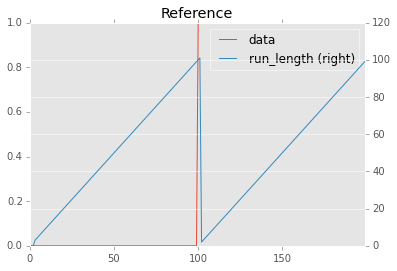

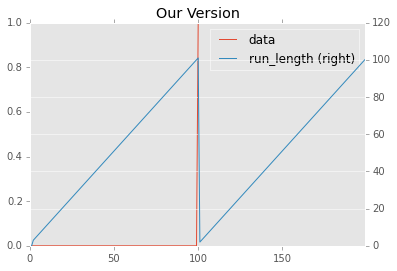

In [5]:
from bcd import offline_changepoint_detection, BayesianChangepointDetection
from bcd.distributions import Gaussian

# ----------------------------- Reference ------------------------------
data = [0] * 100 + [1] * 100
Pr = offline_changepoint_detection(data, hazard(0.6), Gaussian(1, 0, 1, 0.1))

ax = plot_result(data, [Pr[:, t].argmax() for t in range(len(data))])
ax.set_title("Reference")
plt.show()

# ------------------------------ Our Version ------------------------------
detector = BayesianChangepointDetection(hazard(0.6), Gaussian(1, 0, 1, 0.1))
Pr = [detector.step(x) for x in data]

ax = plot_result(data, [pr.argmax() for pr in Pr])
ax.set_title("Our Version")
plt.show()

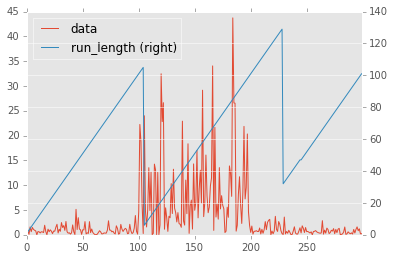

In [6]:
# Exponential Data
data = np.concatenate([np.random.exponential(scale=1, size=100),
                       np.random.exponential(scale=10, size=100),
                       np.random.exponential(scale=1, size=100)])
detector = BayesianChangepointDetection(hazard(0.6), Gaussian(0.1, 4, 1, 30))
Pr = [detector.step(x) for x in data]
ax = plot_result(data, [pr.argmax() for pr in Pr])

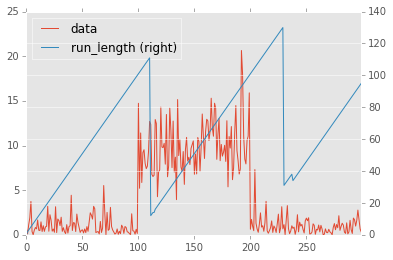

In [7]:
# Gamma
data = np.concatenate([np.random.gamma(1, size=100),
                       np.random.gamma(10, size=100),
                       np.random.gamma(1, size=100)])
detector = BayesianChangepointDetection(hazard(0.6), Gaussian(0.1, 4, 1, 10))
Pr = [detector.step(x) for x in data]
ax = plot_result(data, [pr.argmax() for pr in Pr])

In [8]:
from data.yahoo import get_stock_prices
import datetime as dt

df = get_stock_prices("GOOG", dt.date.today() - dt.timedelta(days=365))

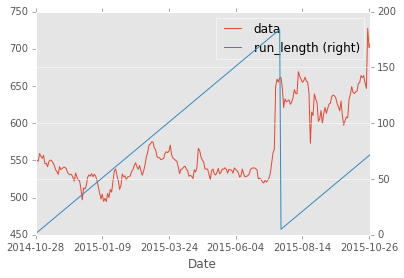

In [9]:
# Change point detection of Google Stock Price
detector = BayesianChangepointDetection(hazard(0.4), Gaussian(0.1, 600, 1, 2000))
df.run_length = pd.Series({date: detector.step(price).argmax() 
                          for date, price in df.Open.iteritems()})
ax = plot_result(df.Open, df.run_length)

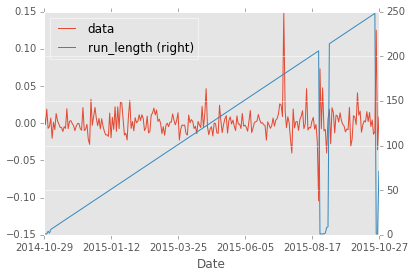

In [10]:
# Change point detection of Google Stock Price Growth

detector = BayesianChangepointDetection(hazard(0.4), Gaussian(0.1, 0.01, 1, 0.005 ** 2))
diff = df.pct_change().dropna()
diff.run_length = pd.Series({date: detector.step(price).argmax() 
                             for date, price in diff.Open.iteritems()})
ax = plot_result(diff.Open, diff.run_length)